<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Artificial-Data" data-toc-modified-id="Generate-Artificial-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Artificial Data</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Priors</a></span></li><li><span><a href="#Fit-the-Model!" data-toc-modified-id="Fit-the-Model!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit the Model!</a></span></li><li><span><a href="#Emcee-Sampler-diagnostics" data-toc-modified-id="Emcee-Sampler-diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Emcee Sampler diagnostics</a></span></li><li><span><a href="#More-diagnostics" data-toc-modified-id="More-diagnostics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More diagnostics</a></span></li><li><span><a href="#Post-Estimation" data-toc-modified-id="Post-Estimation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Post-Estimation</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

import jax

jax.config.update("jax_platform_name", "cpu")
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5)]

In [3]:
import gEconpy as ge
import gEconpy.plotting as gp
from gEconpy.model.statespace import data_from_prior

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

import arviz as az
import preliz as pz

gp.set_matplotlib_style()

# Estimating a DSGE Model

To estimate a model, `gEconpy` uses PyMC, specifically the `pymc-extras` statespace module. To do this, you first have to compile a GCN file to a statespace model using `ge.statespace_from_gcn`.

Like `ge.model_from_gcn`, this will show a build report. Unlike `model_from_gcn`, you will not be able to do experiments with the steady state or linearization. Instead, everything is re-oriented towards estimation.

In [4]:
file_path = "../GCN Files/RBC.gcn"
ss_mod = ge.statespace_from_gcn(file_path, log_linearize=True)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 6 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


Unlike `ge.model_from_gcn`, we do not get back a `gEconpy.Model` object. Instead, we get a `DSGEStateSpace` object. This inherits from class:`pymc_extras.statespace.core.PyMCStatespace`, but extended for extra functionality relevant to DSGE modeling.

In [5]:
type(ss_mod)

gEconpy.model.statespace.DSGEStateSpace

You are still able to see the underlying model equations that were parsed from the GCN file. The parser used to create `DSGEStateSpace` is identical to that used for `Model`.

In [6]:
for eq in ss_mod.equations:
    display(eq)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

Calibrated parameter values are also stored in the `param_dict` property

In [7]:
ss_mod.param_dict

{'alpha': 0.35,
 'beta': 0.99,
 'delta': 0.02,
 'rho_A': 0.95,
 'sigma_C': 1.5,
 'sigma_L': 2.0}

As are the names of the state variables in the model

In [8]:
ss_mod.state_names

['A', 'C', 'I', 'K', 'L', 'Y', 'lambda', 'r', 'w']

And stochastic shock terms

In [9]:
ss_mod.shock_names

['epsilon_A']

In this GCN file, we have defined priors over all 6 parameters. When priors are defined, they are converted into `preliz` distributions. `preliz` is a package dedicated to prior elicidation. It makes it easy to visualize, play with, and adjust distributions. 

All distributions defined in the CGN file are stored in `ss_mod.param_priors`

In [10]:
ss_mod.param_priors

{'beta': Beta(alpha=70, beta=4),
 'delta': Beta(alpha=2, beta=42),
 'sigma_C': Gamma(alpha=7, beta=3),
 'sigma_L': Gamma(alpha=7, beta=3),
 'alpha': Beta(alpha=2, beta=5),
 'rho_A': Beta(mu=0.95, sigma=0.04)}

These can be visualized by using the `.plot_pdf`, `.plot_cdf`, or `.plot_interactive` methods. These have lots of options for adding different statistics to the plot. In the next cell, we make a plot that shows several of these.

<Axes: >

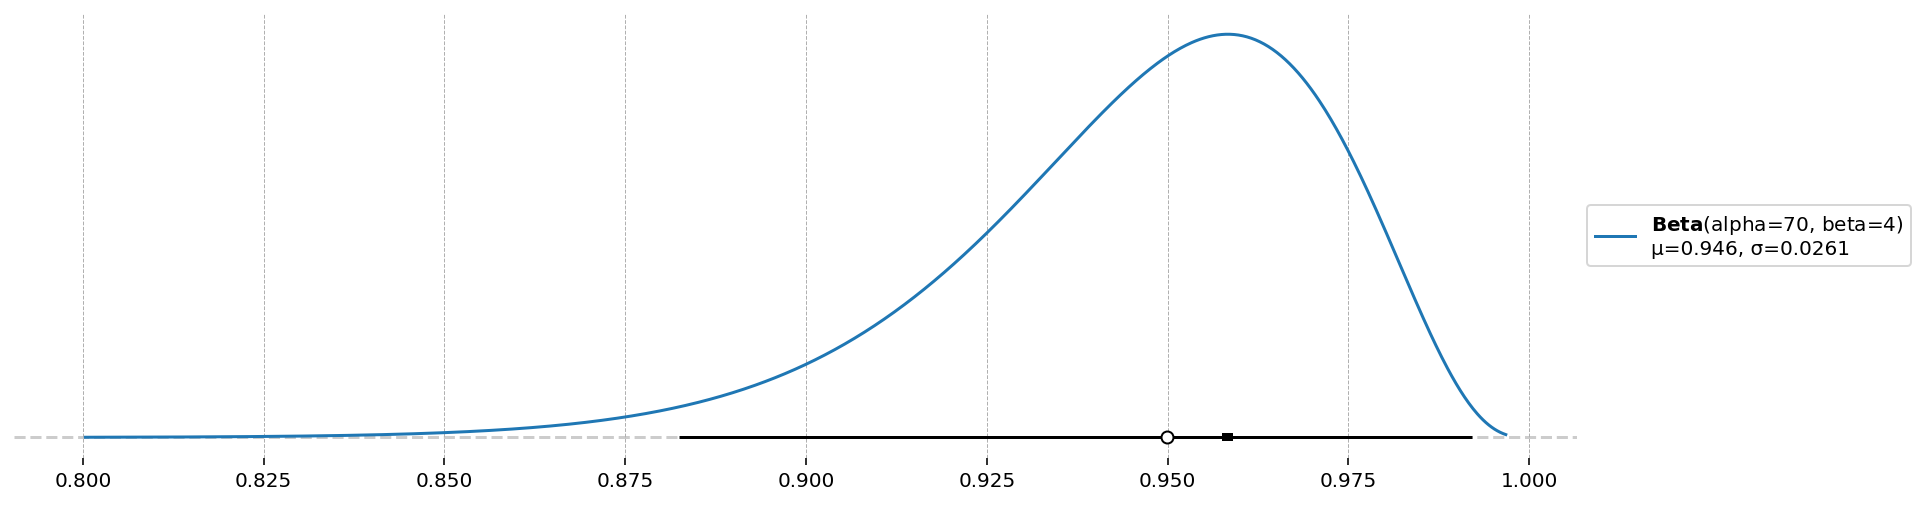

In [11]:
d = ss_mod.param_priors["beta"]
d.plot_pdf(moments="md", pointinterval=True, interval="hdi", levels=(0.025, 0.975))

To plot all priors together, we offer `gEconpy.plotting.plot_priors`. This also drops a veritical line at the calibrated value declared in the GCN file, if any.

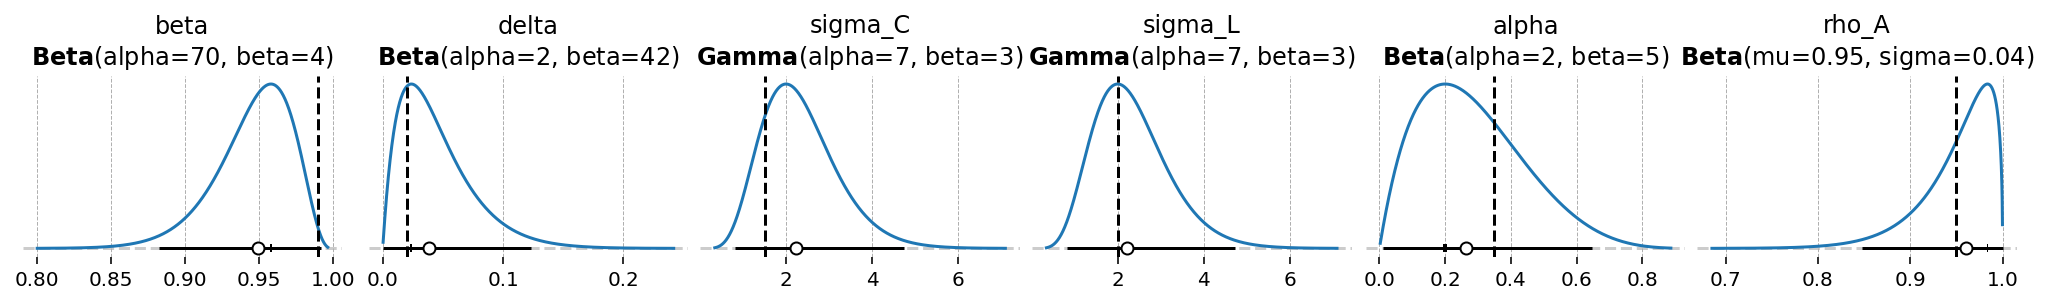

In [12]:
gp.plot_priors(ss_mod);

Declaring priors in a GCN file is totally optional, as is using `preliz`. In the end, you will be able to use any PyMC priors you please, via the `pymc_extras.statespace` API. 

To set up a statespace model, you first have to call the `.configure` method. This finalizes model settings, by allowing you to choose:

- `observed_states`: Which states in the DSGE model are observed 
- `measurement_error`: Which observed states have associated measurement error
- `full_shock_covariance`: Whether to estimate a full shock covariance matrix, or just the diagonal elements
- `mode`: Which computational backend to compile the model `logp` function to. See the pytensor documentation for details about the choices. `mode="JAX"` is strongly recommended.
- `solver`: Which algorithm to use for finding the linear policy function. Choices are `gensys`, `cycle_reduction`, or `scan_cycle_reduction`. Only `scan_cycle_reduction` is supported when `mode="JAX"`.
- `use_adjoint_gradients`: Whether to autodiff through the `cycle_reduction` algorithm (`False`), or to directly use an analytical solution (`True`). The analytical solution is recommended.
- `max_iter`: The maximum number of iterations allowed to the `cycle_reduction` algorithm. Because of how looping works in autodiff, loops must always run for the maximum number of iterators. If convregence is detected before the maximum iteration, computation is replaced with the identity function, but it's still not "free". Thus, a low number (10-20), is recommended here to maximimze performance.

Recall that a statespace model can only have as many observed states as there are sources of stochastic variation. Since this model has only one stochastic shock, we will observe only one variable, `Y`.

In [13]:
ss_mod.configure(
    observed_states=["Y"],
    measurement_error=None,
    full_shock_covaraince=False,
    solver="scan_cycle_reduction",
    mode="JAX",
    use_adjoint_gradients=True,
    max_iter=20,
)

                  Model Requirements                  
                                                      
  Variable          Shape   Constraints   Dimensions  
 ──────────────────────────────────────────────────── 
  alpha             ()                          None  
  beta              ()                          None  
  delta             ()                          None  
  rho_A             ()                          None  
  sigma_C           ()      Positive            None  
  sigma_L           ()      Positive            None  
  sigma_epsilon_A   ()      Positive            None  
                                                      
 These parameters should be assigned priors inside a  
         PyMC model block before calling the          
            build_statespace_graph method.            

After calling the `.configure` method, we recieve this Model Requirements table, telling us what needs to be declared inside a `pm.Model` context. This is done exactly like all statespace models, so check the statespace model documentation for more details. 

As noted above, using `preliz` priors is totally optional. Here we define the entire model with `pymc` priors.

To see how the priors look, we can use `pm.sample_prior_predictive`.

In [14]:
with pm.Model(coords=ss_mod.coords) as pm_mod:
    alpha = pm.Beta("alpha", alpha=2, beta=10)
    beta = pm.Beta("beta", alpha=2, beta=30)
    delta = pm.Beta("delta", alpha=1, beta=30)
    rho_A = pm.Beta("rho_A", alpha=10, beta=2)
    sigma_C = pm.TruncatedNormal("sigma_C", mu=1.5, sigma=2, lower=1.01, upper=np.inf)
    sigma_L = pm.TruncatedNormal("sigma_L", mu=1.5, sigma=2, lower=1, upper=np.inf)
    sigma_epsilon_A = pm.Exponential("sigma_epsilon_A", 10)

    priors = pm.sample_prior_predictive(draws=2000)

Sampling: [alpha, beta, delta, rho_A, sigma_C, sigma_L, sigma_epsilon_A]


In [15]:
az.summary(priors.prior)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_C          2.757  1.280   1.011    5.055      0.029    0.021    1826.0   
delta            0.032  0.031   0.000    0.090      0.001    0.000    1819.0   
beta             0.063  0.044   0.001    0.143      0.001    0.001    2034.0   
alpha            0.168  0.104   0.004    0.356      0.002    0.002    1909.0   
sigma_epsilon_A  0.102  0.100   0.000    0.293      0.002    0.002    1833.0   
rho_A            0.836  0.104   0.639    0.983      0.002    0.002    1930.0   
sigma_L          2.772  1.292   1.003    5.033      0.030    0.021    1855.0   

                 ess_tail  r_hat  
sigma_C            1845.0    NaN  
delta              1688.0    NaN  
beta               1830.0    NaN  
alpha              1812.0    NaN  
sigma_epsilon_A    1592.0    NaN  
rho_A              1922.0    NaN  
sigma_L            1677.0    NaN

In [16]:
from corner import corner

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


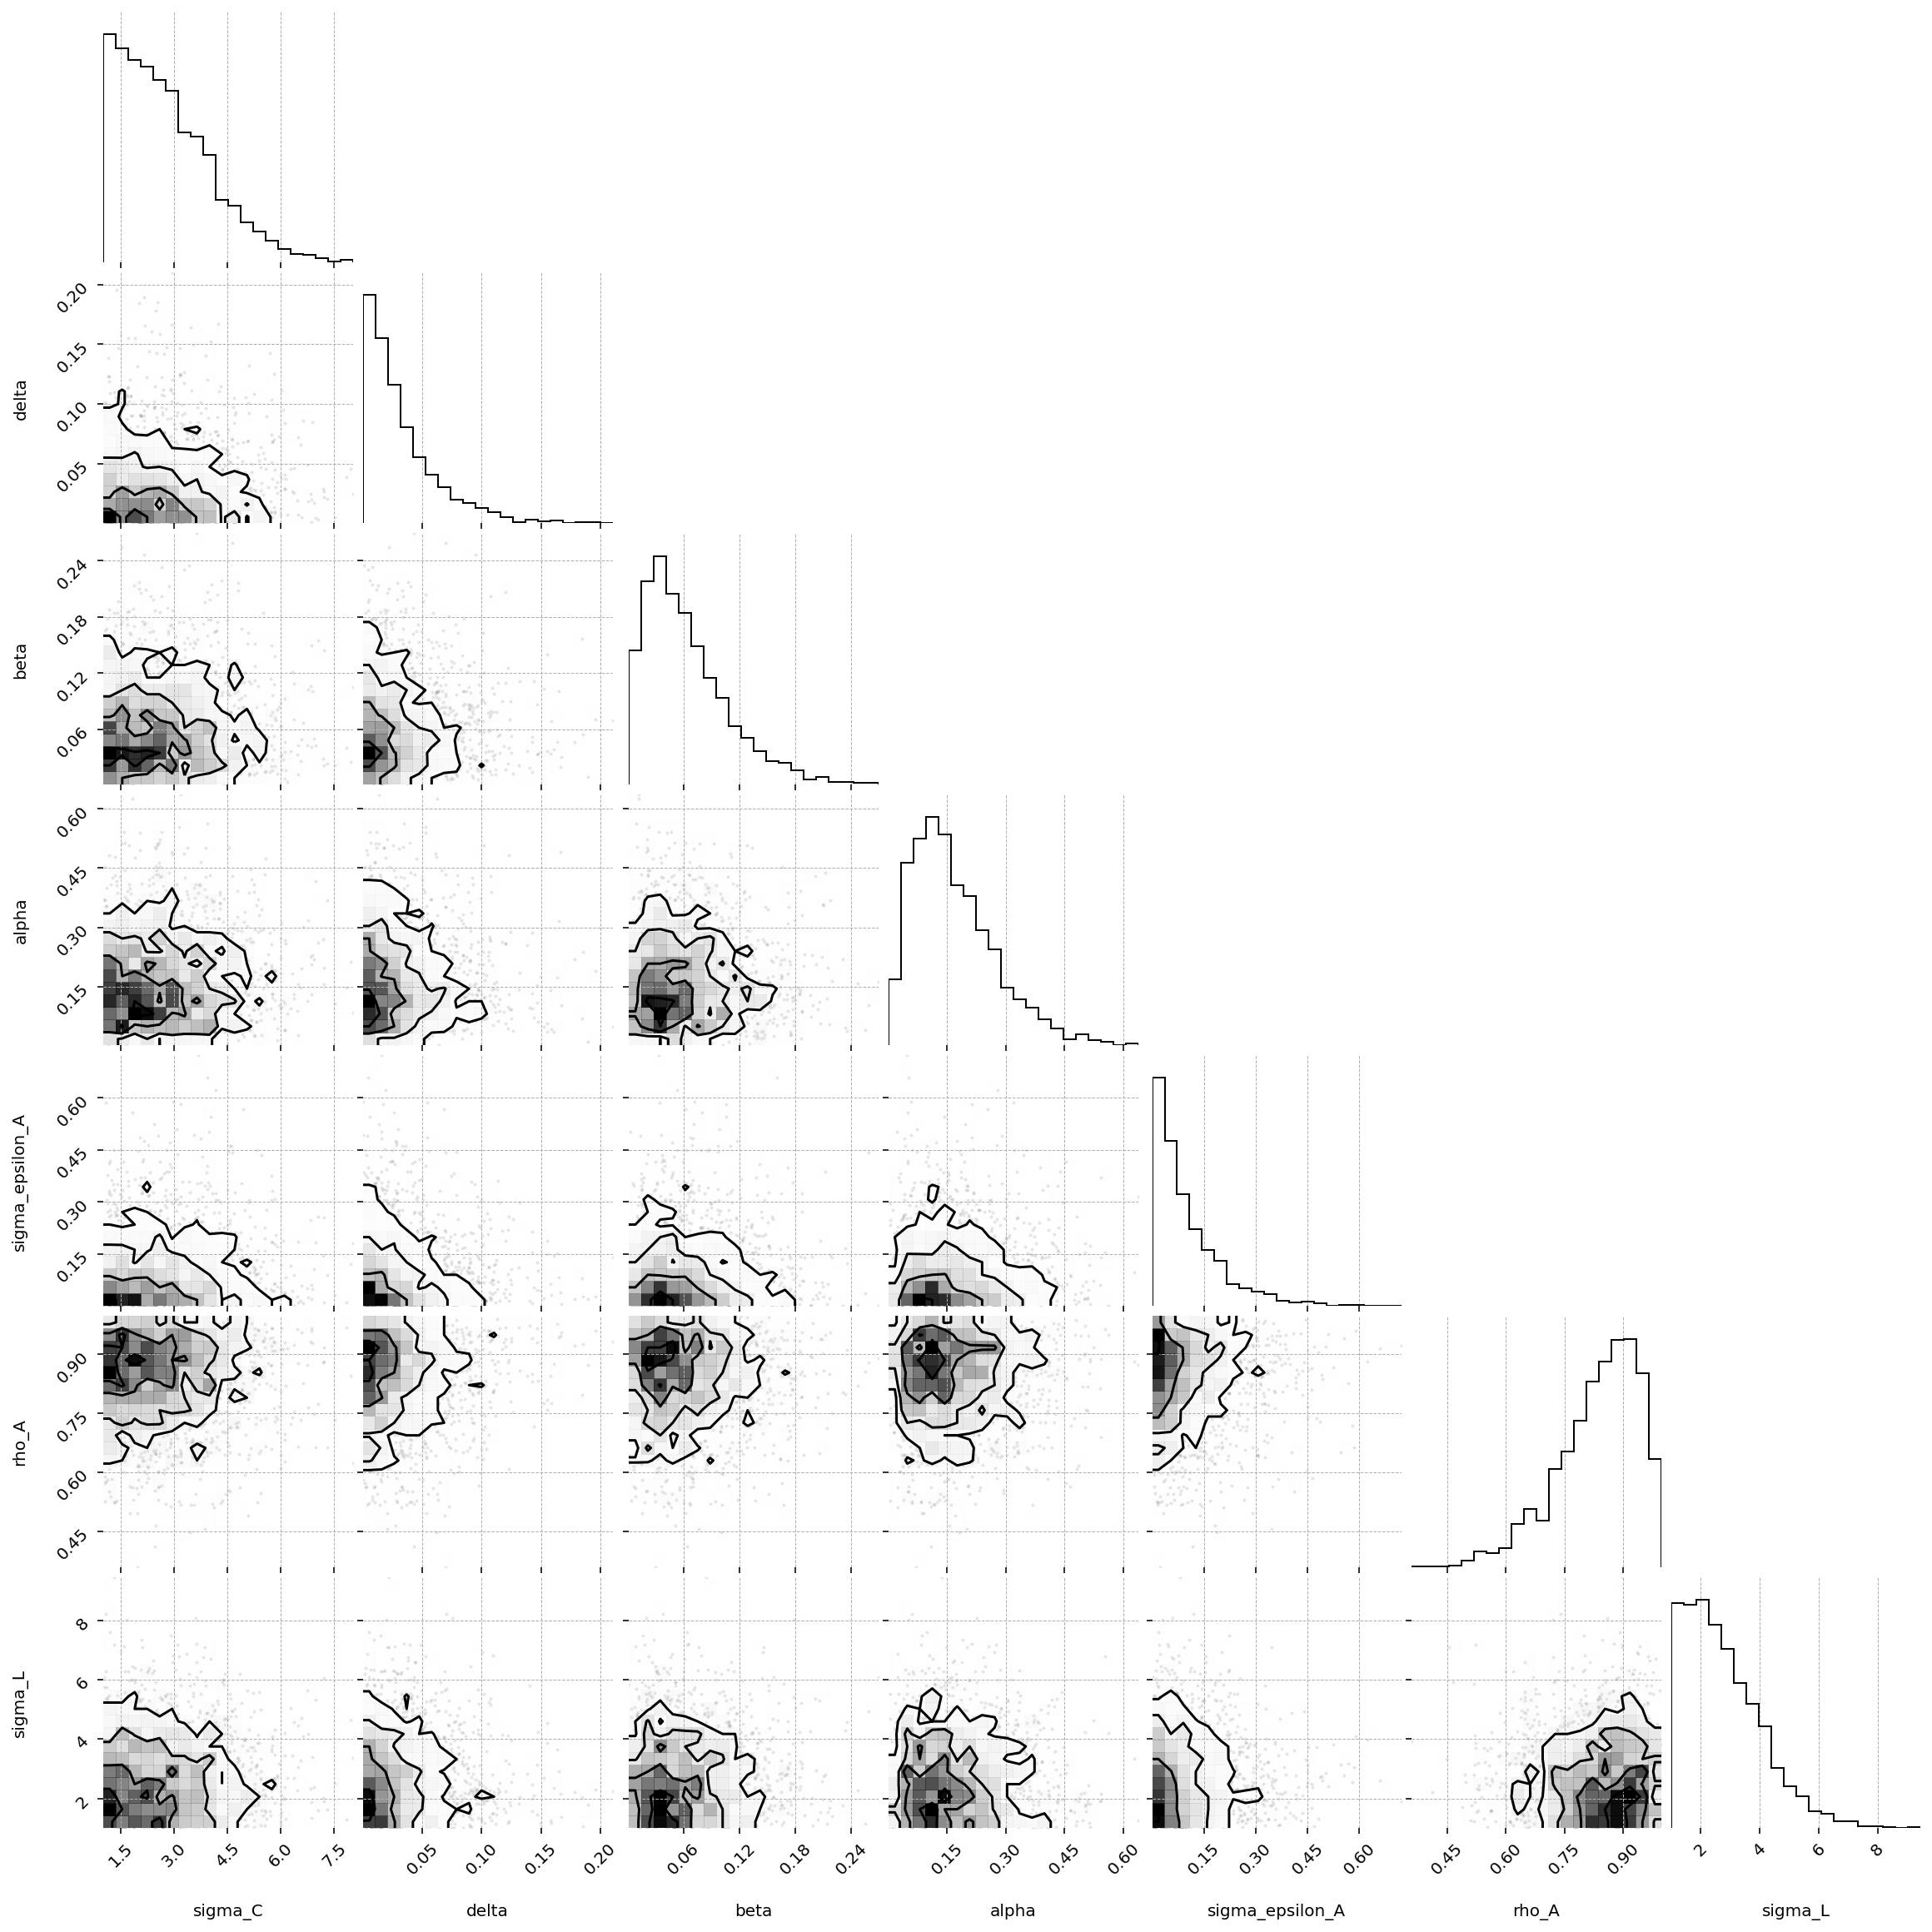

In [17]:
fig = corner(
    priors,
    group="prior",
    figure_kwargs={"figsize": (8, 8), "dpi": 144, "layout": "constrained"},
);

Since priors were defined in the GCN file, we can load those priors using `ss_mod.to_pymc()`. You will still need to manually define priors for those which were not included. In this case, we need to manually give a prior to `sigma_epsilon_A`.

In [18]:
with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    sigma_epsilon_A = pm.Exponential("sigma_epsilon_A", 10)
    prior = pm.sample_prior_predictive(2000)

Sampling: [alpha, beta, delta, rho_A, sigma_C, sigma_L, sigma_epsilon_A]


In [19]:
prior_dict = ss_mod.param_priors | {"sigma_epsilon_A": pz.Exponential(10)}

In [20]:
az.summary(priors.prior)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_C          2.757  1.280   1.011    5.055      0.029    0.021    1826.0   
delta            0.032  0.031   0.000    0.090      0.001    0.000    1819.0   
beta             0.063  0.044   0.001    0.143      0.001    0.001    2034.0   
alpha            0.168  0.104   0.004    0.356      0.002    0.002    1909.0   
sigma_epsilon_A  0.102  0.100   0.000    0.293      0.002    0.002    1833.0   
rho_A            0.836  0.104   0.639    0.983      0.002    0.002    1930.0   
sigma_L          2.772  1.292   1.003    5.033      0.030    0.021    1855.0   

                 ess_tail  r_hat  
sigma_C            1845.0    NaN  
delta              1688.0    NaN  
beta               1830.0    NaN  
alpha              1812.0    NaN  
sigma_epsilon_A    1592.0    NaN  
rho_A              1922.0    NaN  
sigma_L            1677.0    NaN

Either way, once we're happy, we can call `ss_mod.build_statespace_graph`, passing in observed data. In this case we don't have observed data, so we will need to generate some from the priors. A helper function, `data_from_priors`, is available to help you do that.

This prior predictive workflow is also useful for checking model calibration and identification. If you cannot recover "true" parameter values when data are actually generated by the model, you either have a model error, or you need to go back to the drawing board. 

In [21]:
true_params, data, prior_idata = data_from_prior(ss_mod, pm_mod)

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [alpha, beta, delta, obs, rho_A, sigma_C, sigma_L, sigma_epsilon_A]
Sampling: [prior_combined]


Output()

`data_from_prior` returns many parameter draws from the prior, along with model trajectories generated using those parameter draws. It also selects a single draw and splits off 1) a trajectory over observed data for that draw (that is, data with measurement error, if any), and the parameter values that were used to generate that data. 

Here is the trajectory over log deviation from steady-state GDP that was generated by the priors

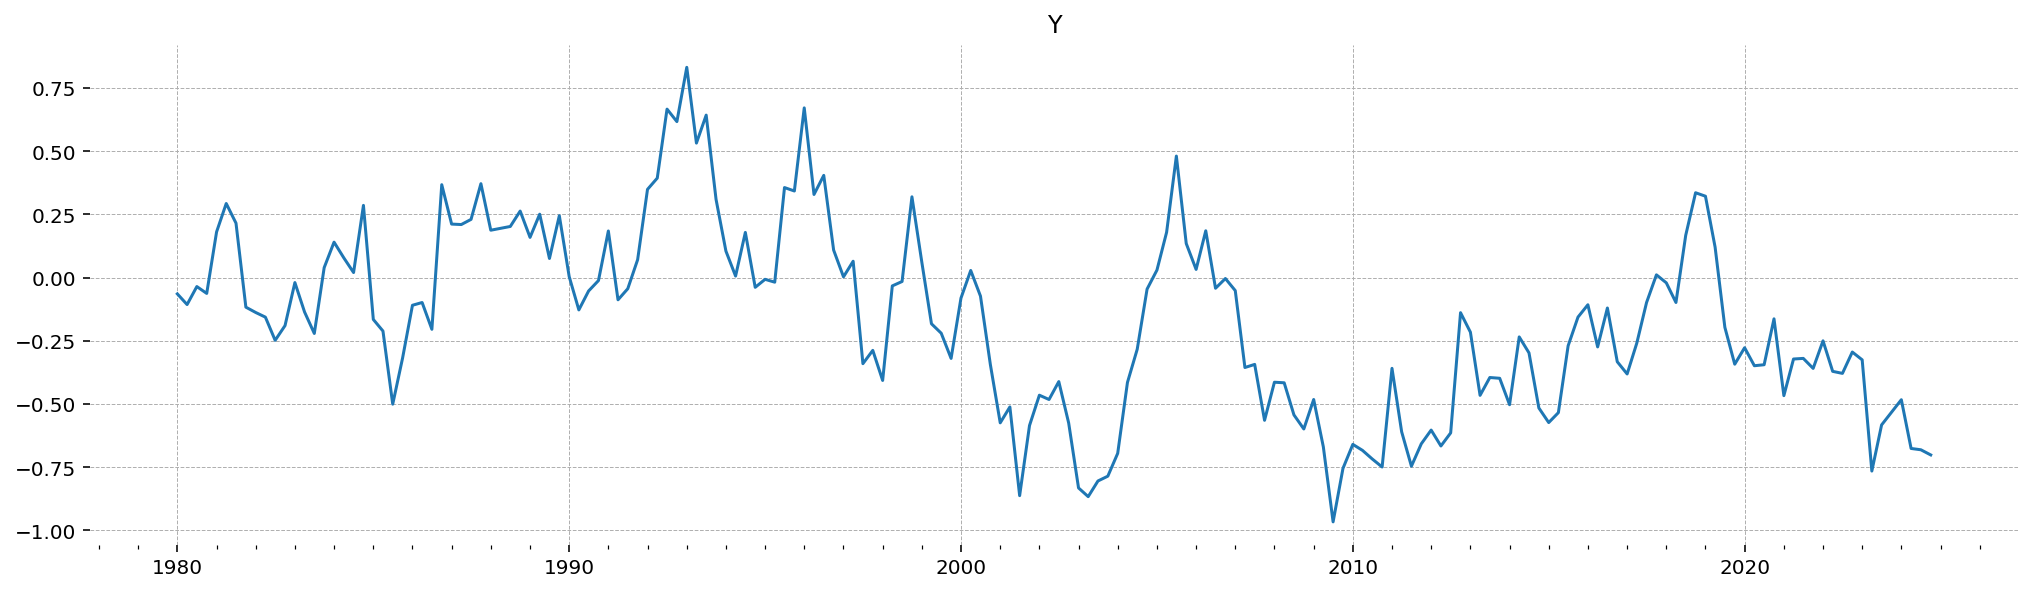

In [22]:
gp.plot_timeseries(data);

And we can also check the parameter values that generated that draw. We also get back a couple diagonostic values, including:

- `ss_resid`: The residual of the steady-state at the parameter draw
- `deterministic_norm`: The norm assoicated with inaccuracies in the deterministic part of the statespace
- `stochastic_norm`: The norm associated with inaccuracies in the stochastic part of the statespace
- `n_cycle_steps`: How many steps of cycle reduction were necessary to compute the policy function
- `param_idx`: The index associated with the draw chosen for the fake data.

In [23]:
true_params

<xarray.Dataset> Size: 120B
Dimensions:             ()
Coordinates:
    chain               int64 8B 0
    draw                int64 8B 118
Data variables: (12/13)
    sigma_C             float64 8B 2.397
    delta               float64 8B 0.04008
    beta                float64 8B 0.945
    alpha               float64 8B 0.1785
    n_cycle_steps       int64 8B 8
    deterministic_norm  float64 8B 9.054e-16
    ...                  ...
    ss_resid            float64 8B 1.592e-30
    policy_resid        float64 8B 8.197e-31
    sigma_epsilon_A     float64 8B 0.2057
    rho_A               float64 8B 0.925
    sigma_L             float64 8B 3.646
    param_idx           int64 8B 118
Attributes:
    created_at:                 2025-02-26T14:25:08.182117+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

Since we know the draw, we can also go in and check the "true" latent states (the model states that are not observed), and see how well we do at recovering those after estimation.

In [24]:
latent_data = (
    prior_idata.unconditional_prior.prior_latent.sel(
        chain=0, draw=true_params.param_idx
    )
    .to_dataframe()
    .loc[:, "prior_latent"]
    .unstack("state")
)

Note that since there is no measurement error in this model, the latent Y and the observed Y will be identical.

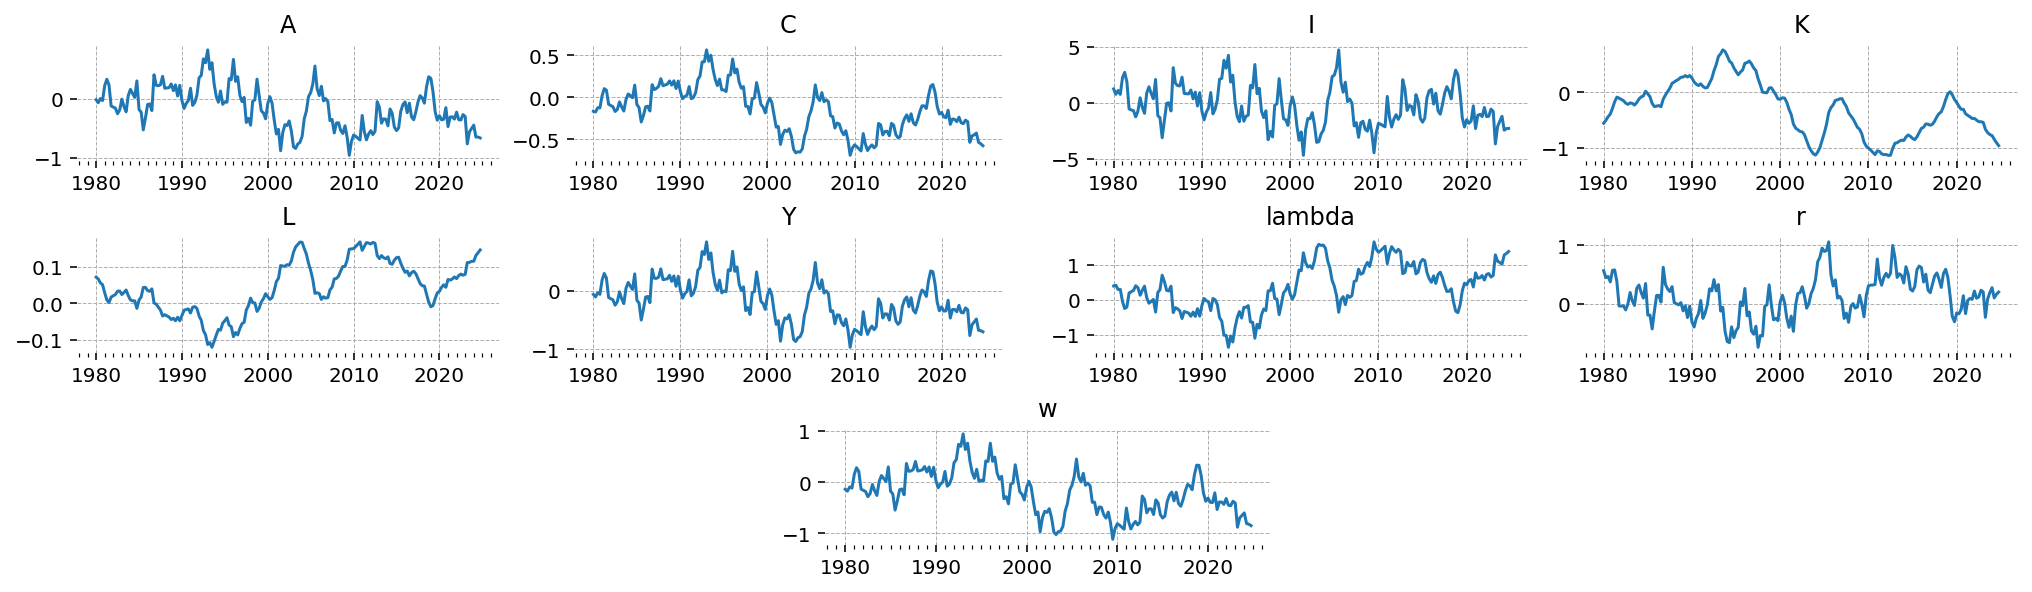

In [25]:
gp.plot_timeseries(latent_data);

# Estimating the Model

To actually estimate the model, the first thing we have to do is to call `ss_mod.build_statespace_graph` inside the PyMC model context. This method has several options related to penalty terms we can add to the loglikelihood. It is recommended to add all of these, as they bias the model away from parameter values that don't result in a steady state solution, or that don't satisfy Blanchard-Kahn conditions.

In [26]:
with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    sigma_epsilon_A = pz.maxent(pz.Gamma(), lower=0.1, upper=1, plot=False)
    sigma_epsilon_A.to_pymc("sigma_epsilon_A")
    ss_mod.build_statespace_graph(
        data,
        add_norm_check=True,
        add_solver_success_check=True,
        add_steady_state_penalty=True,
    )

To actually fit the model, many algorithms are available. `gEconpy` uses `pytensor` to construct a fully differentiable computational graph, allowing access to gradients and even hessians of any scalar loss function you like. Typically, however, we just work with the log probability of the data under the model.

The simplest way thing to do is to directly minimize the logp. In the Bayesian literature, this is called Maximum a Posteriori (MAP) estimation. It can be combined with a Laplace (or Quadratic) approximation to obtain posterior distributions. Using this method, the inverse Hessian of the logp is used as a covariance matrix, and the posterior is approximated as a Multivariate normal distribution.

To do MAP estimation, use `pymc_extras.fit_laplace`

In [27]:
from pymc_extras import fit_laplace

with pm_mod:
    idata_laplace = fit_laplace(
        optimize_method="trust-ncg",
        gradient_backend="jax",
        compile_kwargs={"mode": "JAX"},
        optimizer_kwargs={"tol": 1e-12},
    )

Output()

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/arviz/data/inference_data.py:1546: UserWarning: The group fit is not defined in the InferenceData scheme
  warnings.warn(


Output()

In [28]:
deep_params = ss_mod.param_names
az.summary(idata_laplace, var_names=deep_params)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            0.082  0.087  -0.077    0.238      0.003    0.002    1110.0   
beta             0.954  0.024   0.910    0.999      0.001    0.001     950.0   
delta            0.024  0.024  -0.021    0.068      0.001    0.001     892.0   
rho_A            0.930  0.030   0.876    0.987      0.001    0.001     993.0   
sigma_C          2.386  0.945   0.585    4.103      0.033    0.024     811.0   
sigma_L          1.685  0.794   0.339    3.241      0.028    0.020     794.0   
sigma_epsilon_A  0.202  0.044   0.124    0.283      0.001    0.001     972.0   

                 ess_tail  r_hat  
alpha               916.0    1.0  
beta                982.0    1.0  
delta              1021.0    1.0  
rho_A               985.0    1.0  
sigma_C             921.0    1.0  
sigma_L             889.0    1.0  
sigma_epsilon_A     942.0    1.0

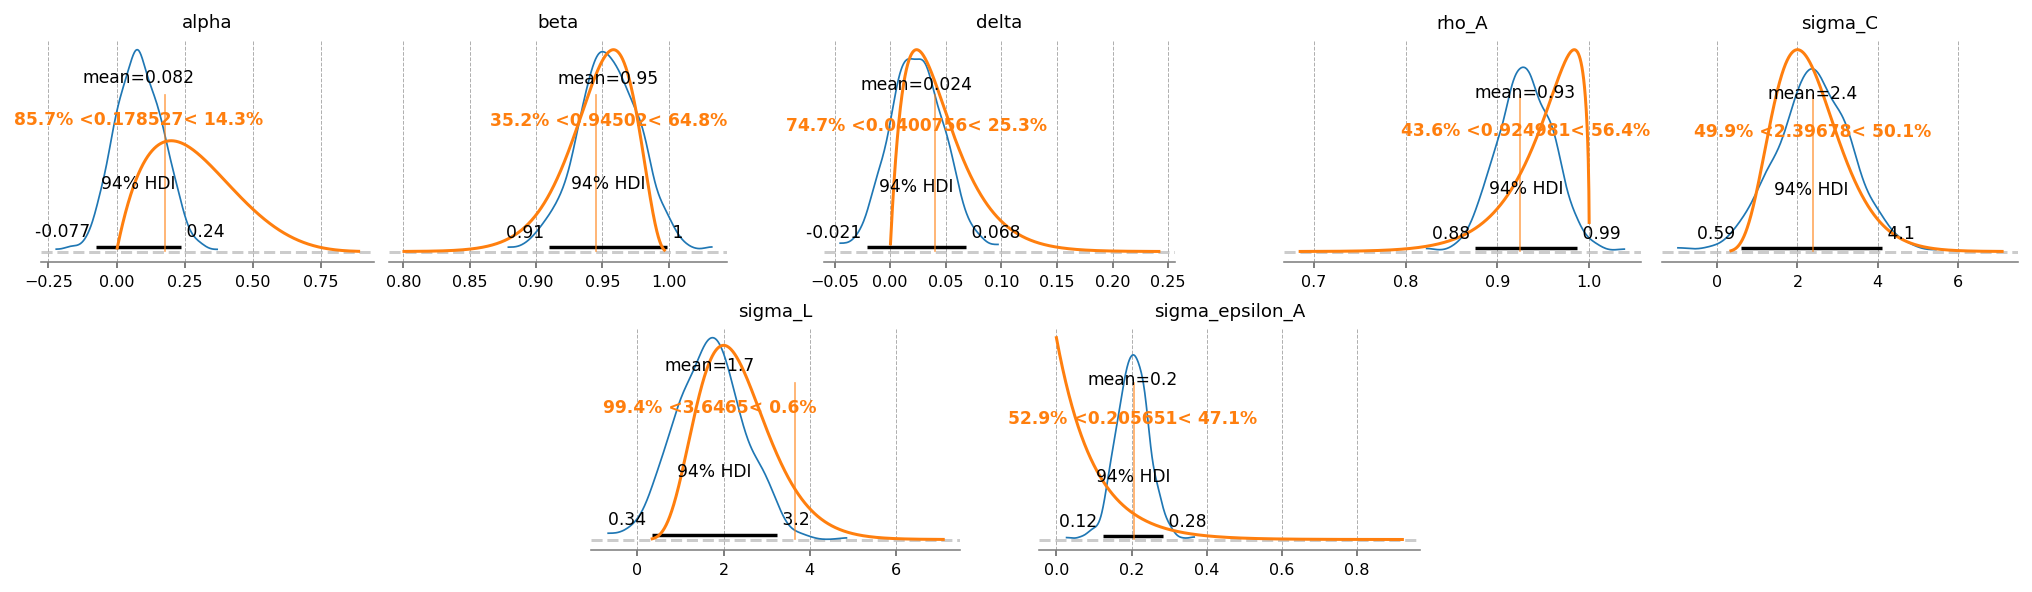

In [29]:
gp.plot_posterior_with_prior(
    idata=idata_laplace,
    true_values=true_params,
    prior_dict=prior_dict,
    var_names=deep_params,
    fig_kwargs={"figsize": (14, 4), "dpi": 144},
    plot_posterior_kwargs={"textsize": 8},
);

## MCMC 

Another option is to approximate the posterior using Markov Chain Monte Carlo.

## Metropolis-Hastings

The "traditional" MCMC method is metropolis-hastings. This is what Dynare uses. It's a very simple, gradient free algorithm. We can use this as well in PyMC by specifiying `step=pm.Metropolis()`

In [30]:
with pm_mod:
    idata_mh = pm.sample(
        step=pm.Metropolis(compile_kwargs={"mode": "JAX"}, blocked=True),
        cores=1,
        chains=4,
        compile_kwargs={"mode": "JAX"},
        mp_ctx="forkserver",
    )

Sequential sampling (4 chains in 1 job)
Metropolis: [beta, delta, sigma_C, sigma_L, alpha, rho_A, sigma_epsilon_A]


Output()

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/tensor/slinalg.py:506: LinAlgWarning:
Ill-conditioned matrix (rcond=8.15883e-17): result may not be accurate.
  outputs[0][0] = scipy_linalg.solve(

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/tensor/slinalg.py:506: LinAlgWarning:
Ill-conditioned matrix (rcond=8.15885e-17): result may not be accurate.
  outputs[0][0] = scipy_linalg.solve(

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 306 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


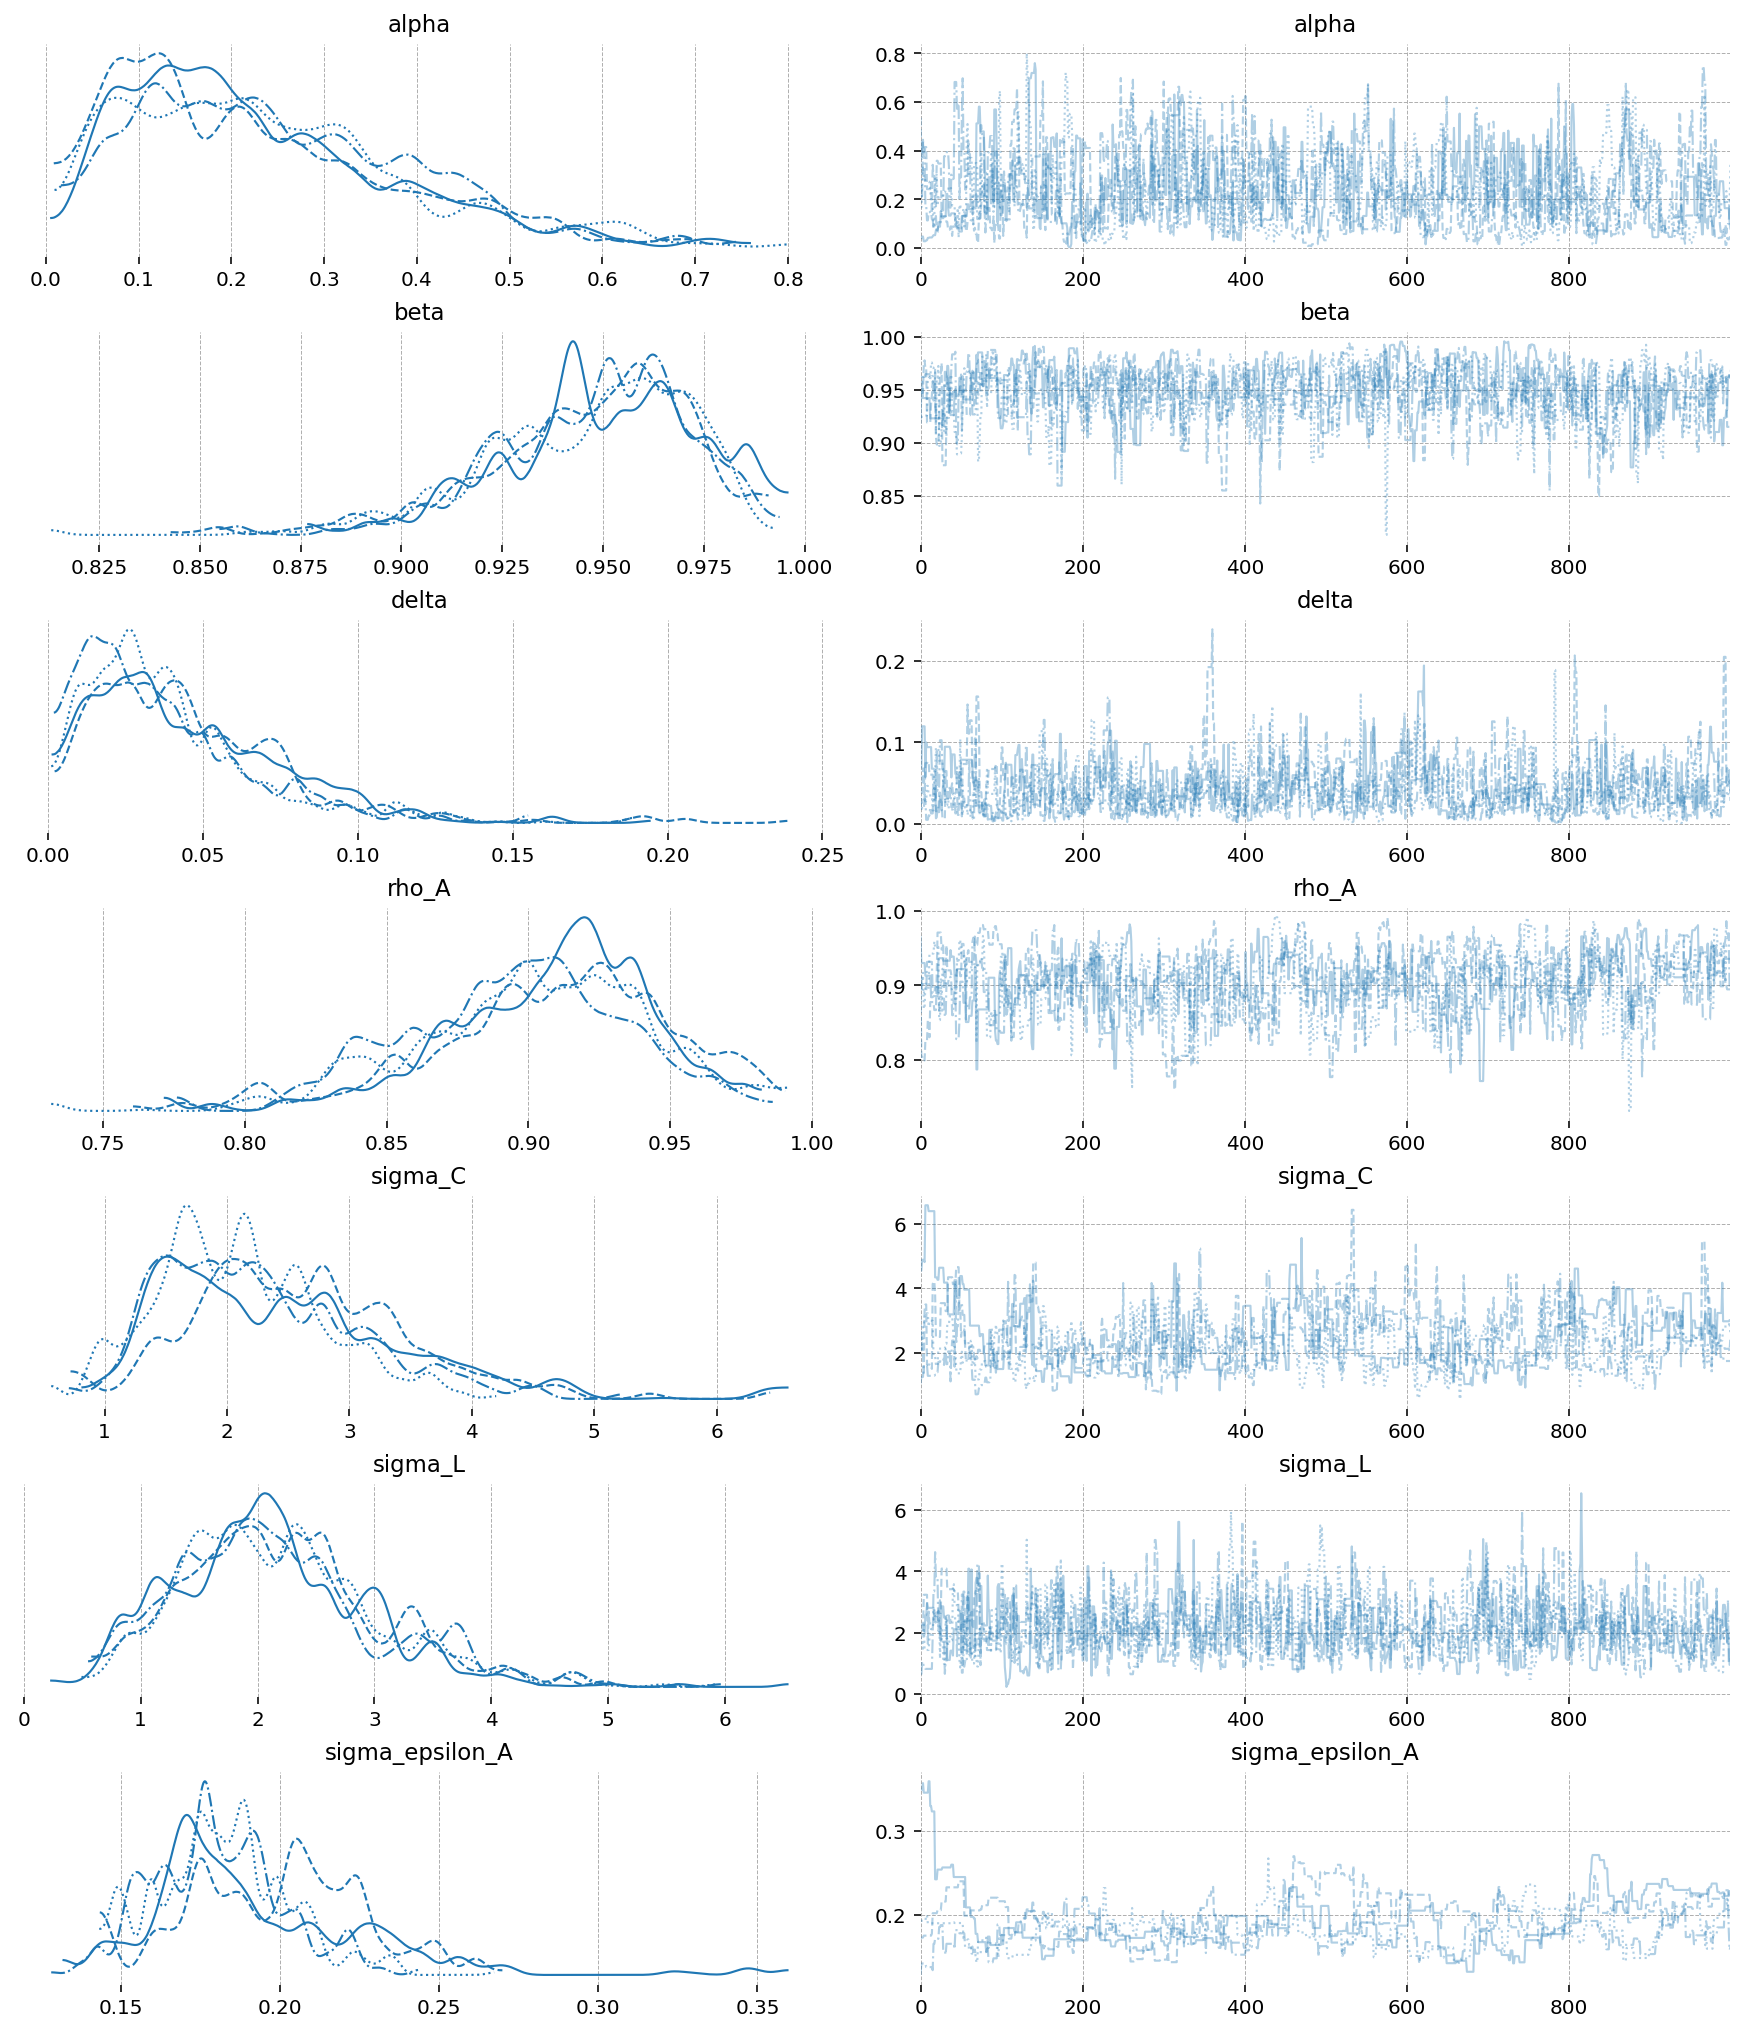

In [31]:
az.plot_trace(idata_mh, var_names=deep_params);

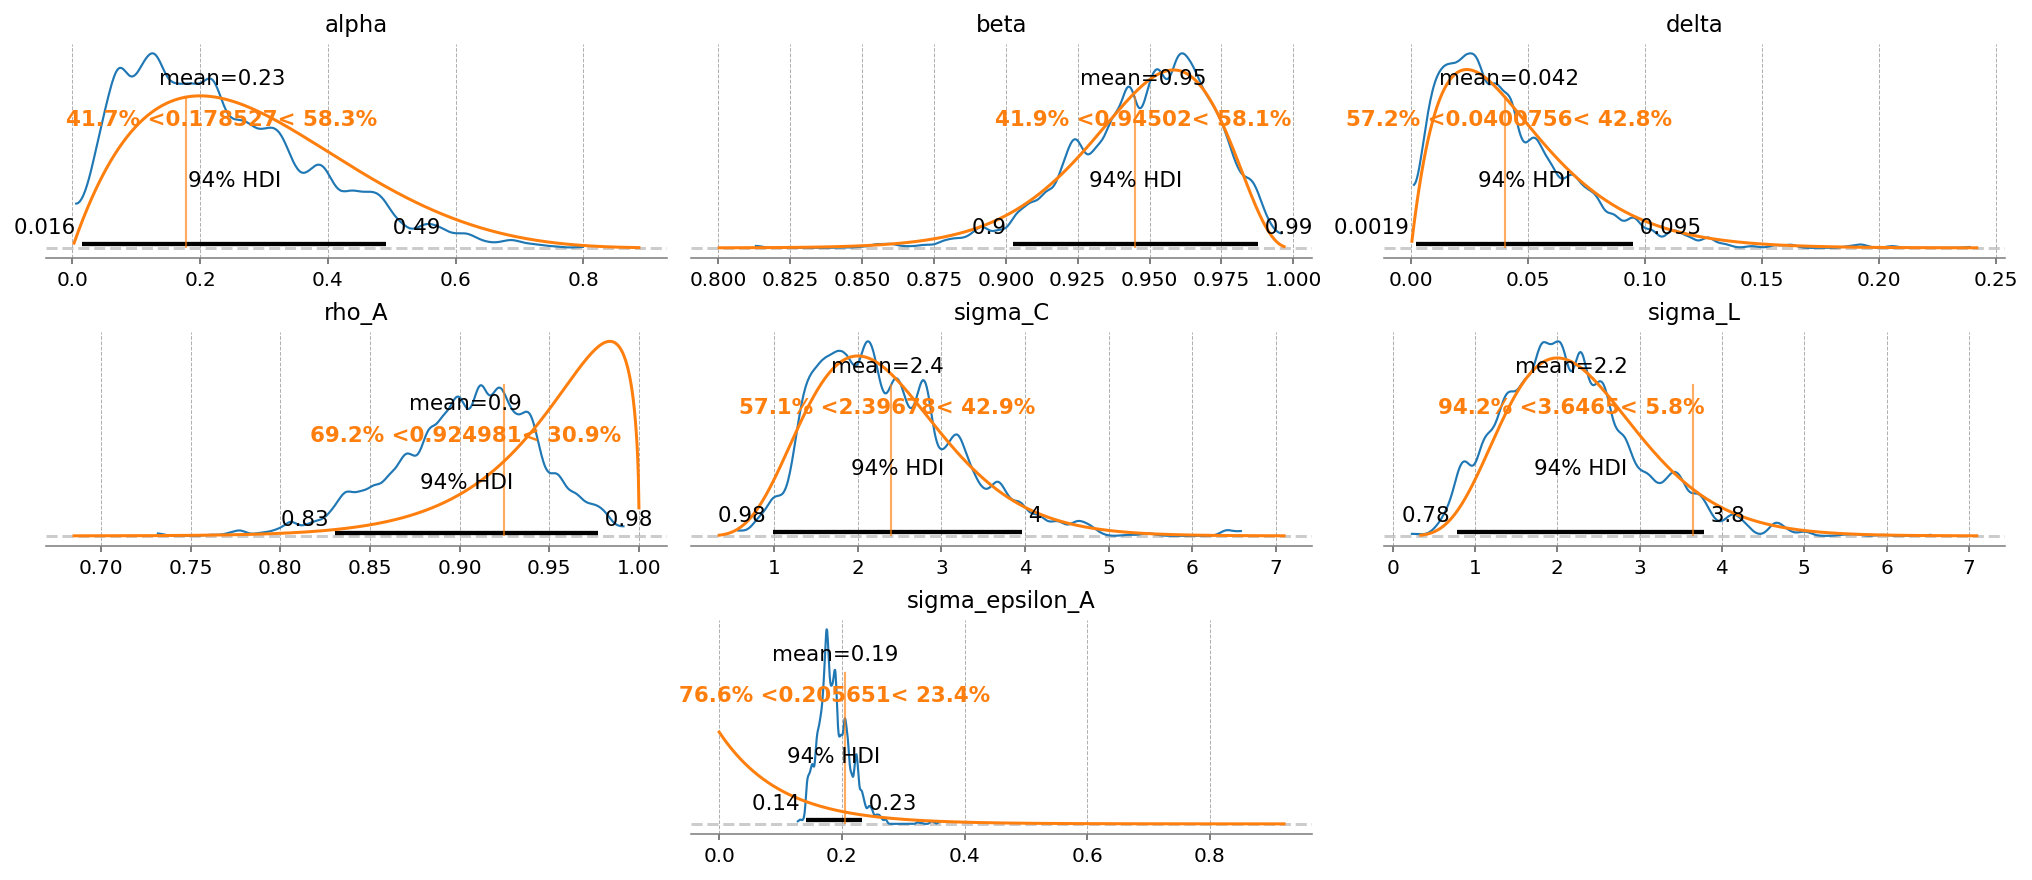

In [32]:
gp.plot_posterior_with_prior(
    idata_mh,
    var_names=deep_params,
    prior_dict=prior_dict,
    true_values=true_params,
    n_cols=3,
);

## NUTS

A muhc better choice is NUTS, which is a state-of-the-art implementation of Hamiltonian Monte-Carlo. The best implementation is in `nutpie`. This too can be accessed through PyMC. We need to set the compile backend to JAX to make it work.

In [33]:
with pm_mod:
    idata_nuts = pm.sample(
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        cores=4,
        chains=4,
        target_accept=0.9,
    )

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1057: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1057: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


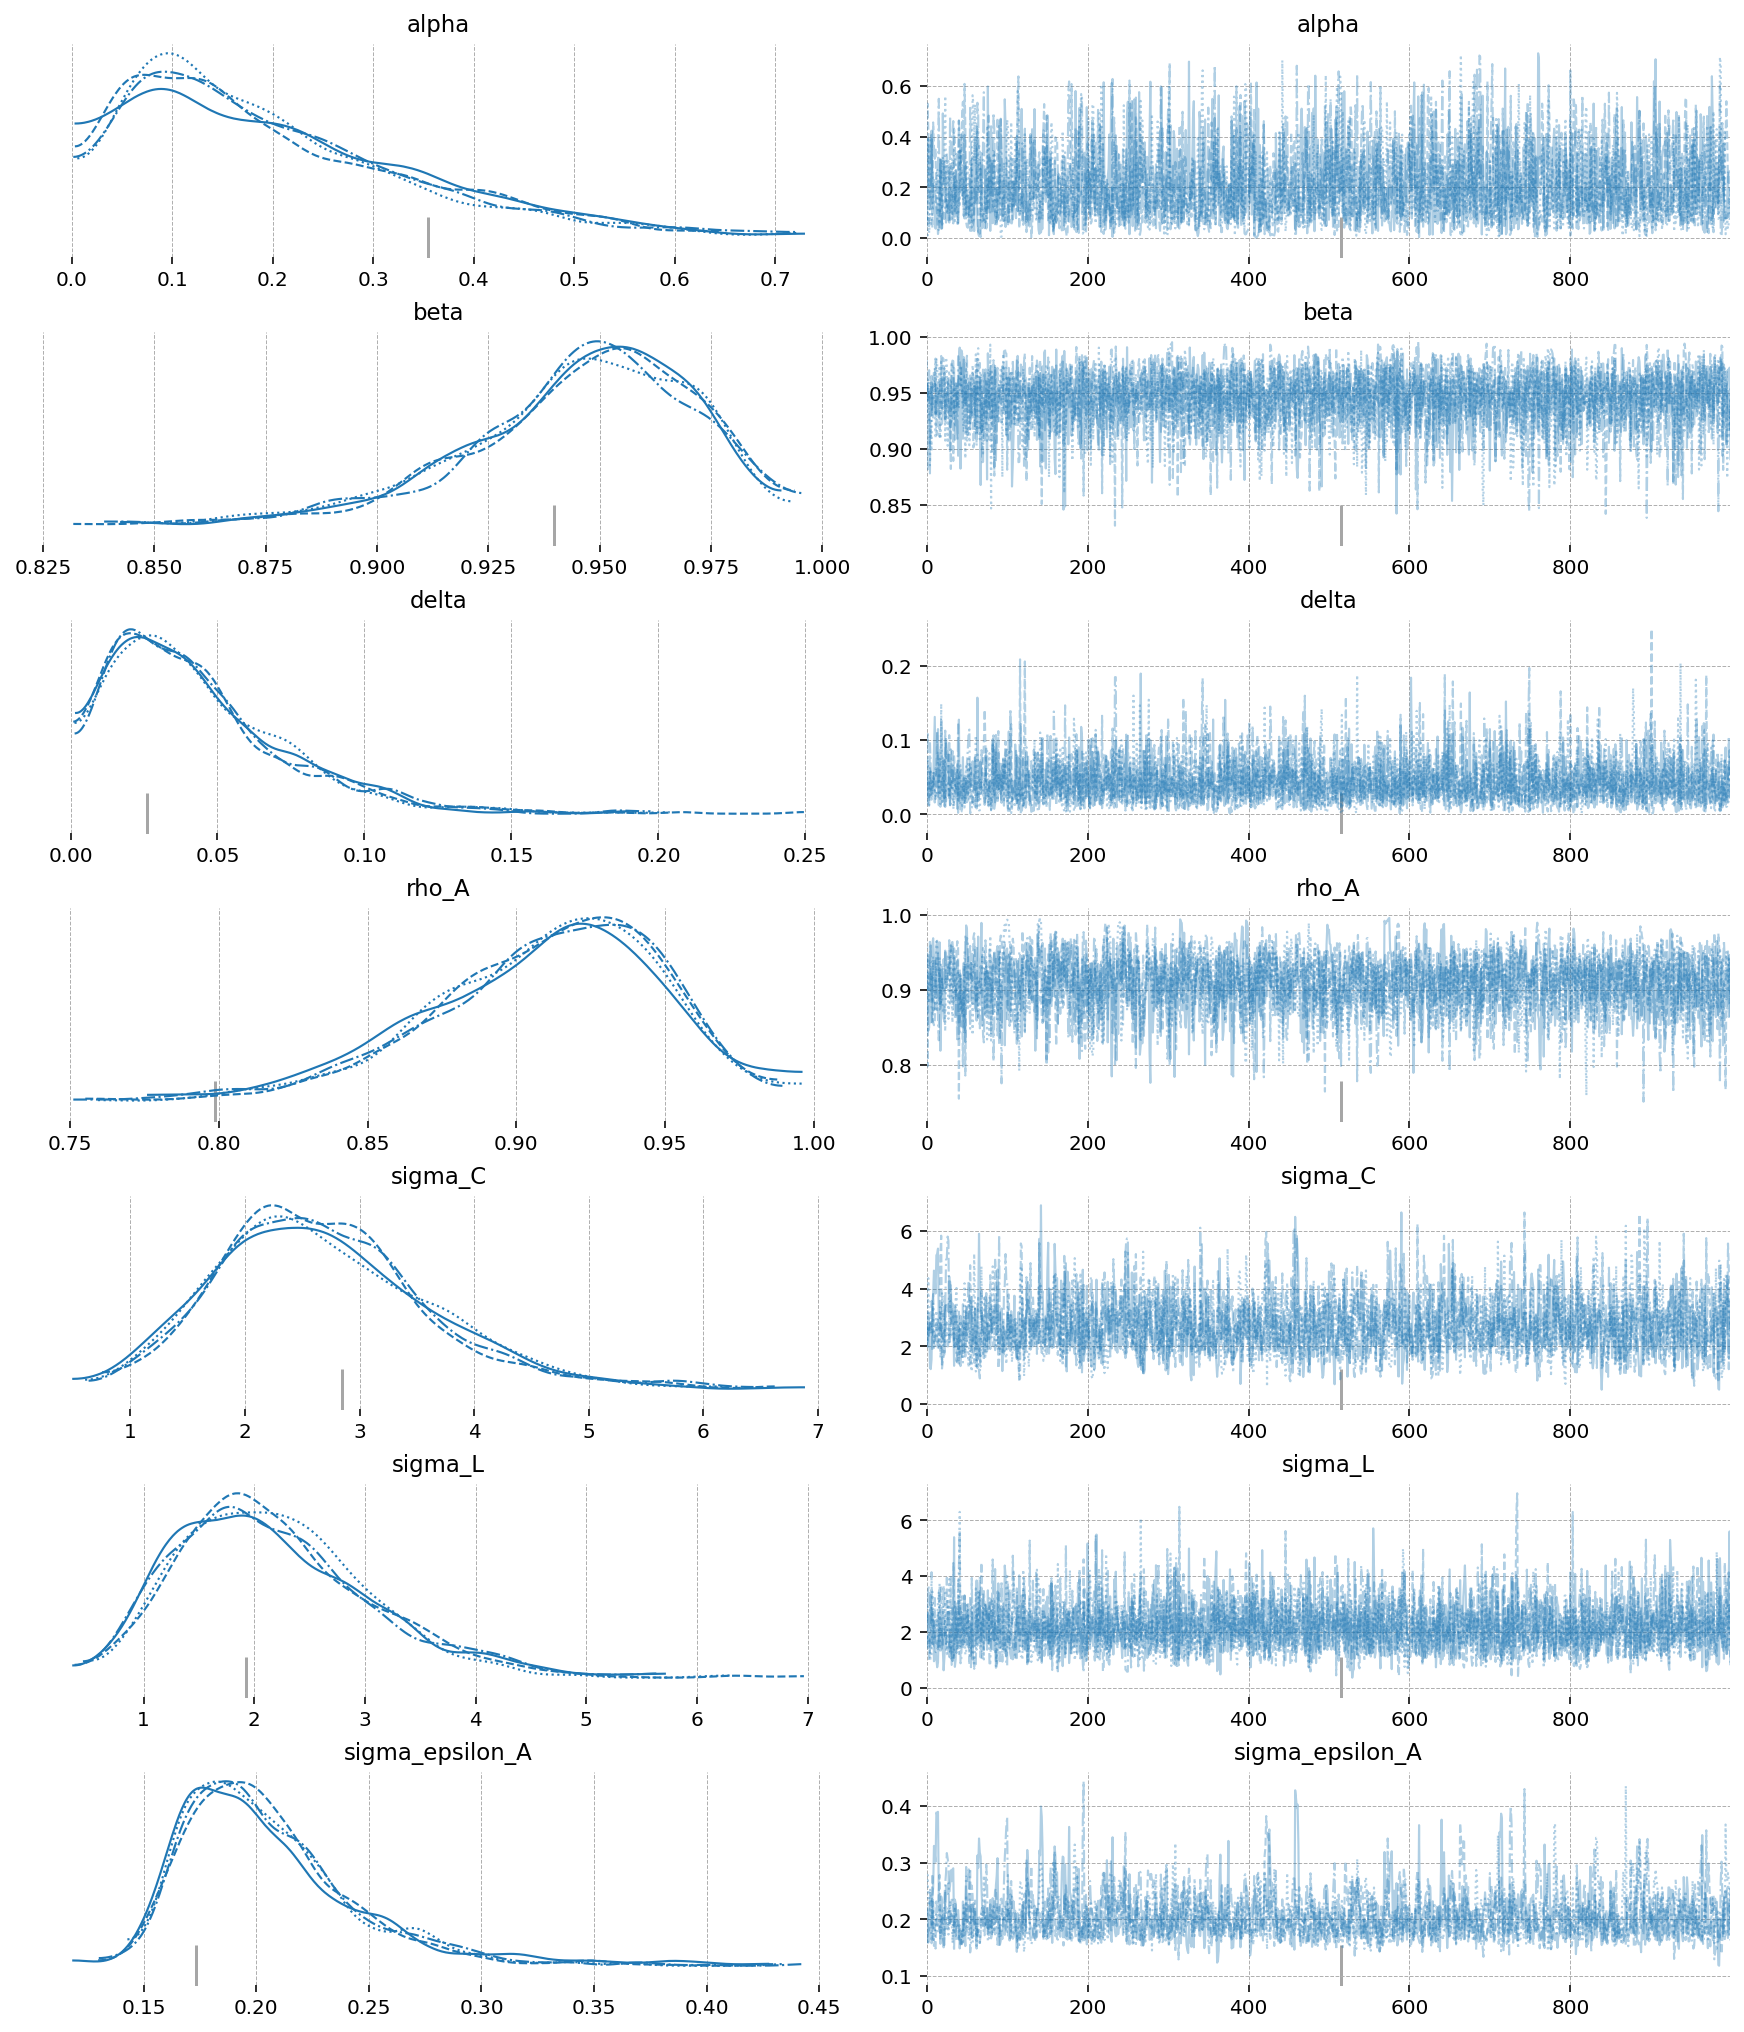

In [34]:
az.plot_trace(idata_nuts, var_names=deep_params);

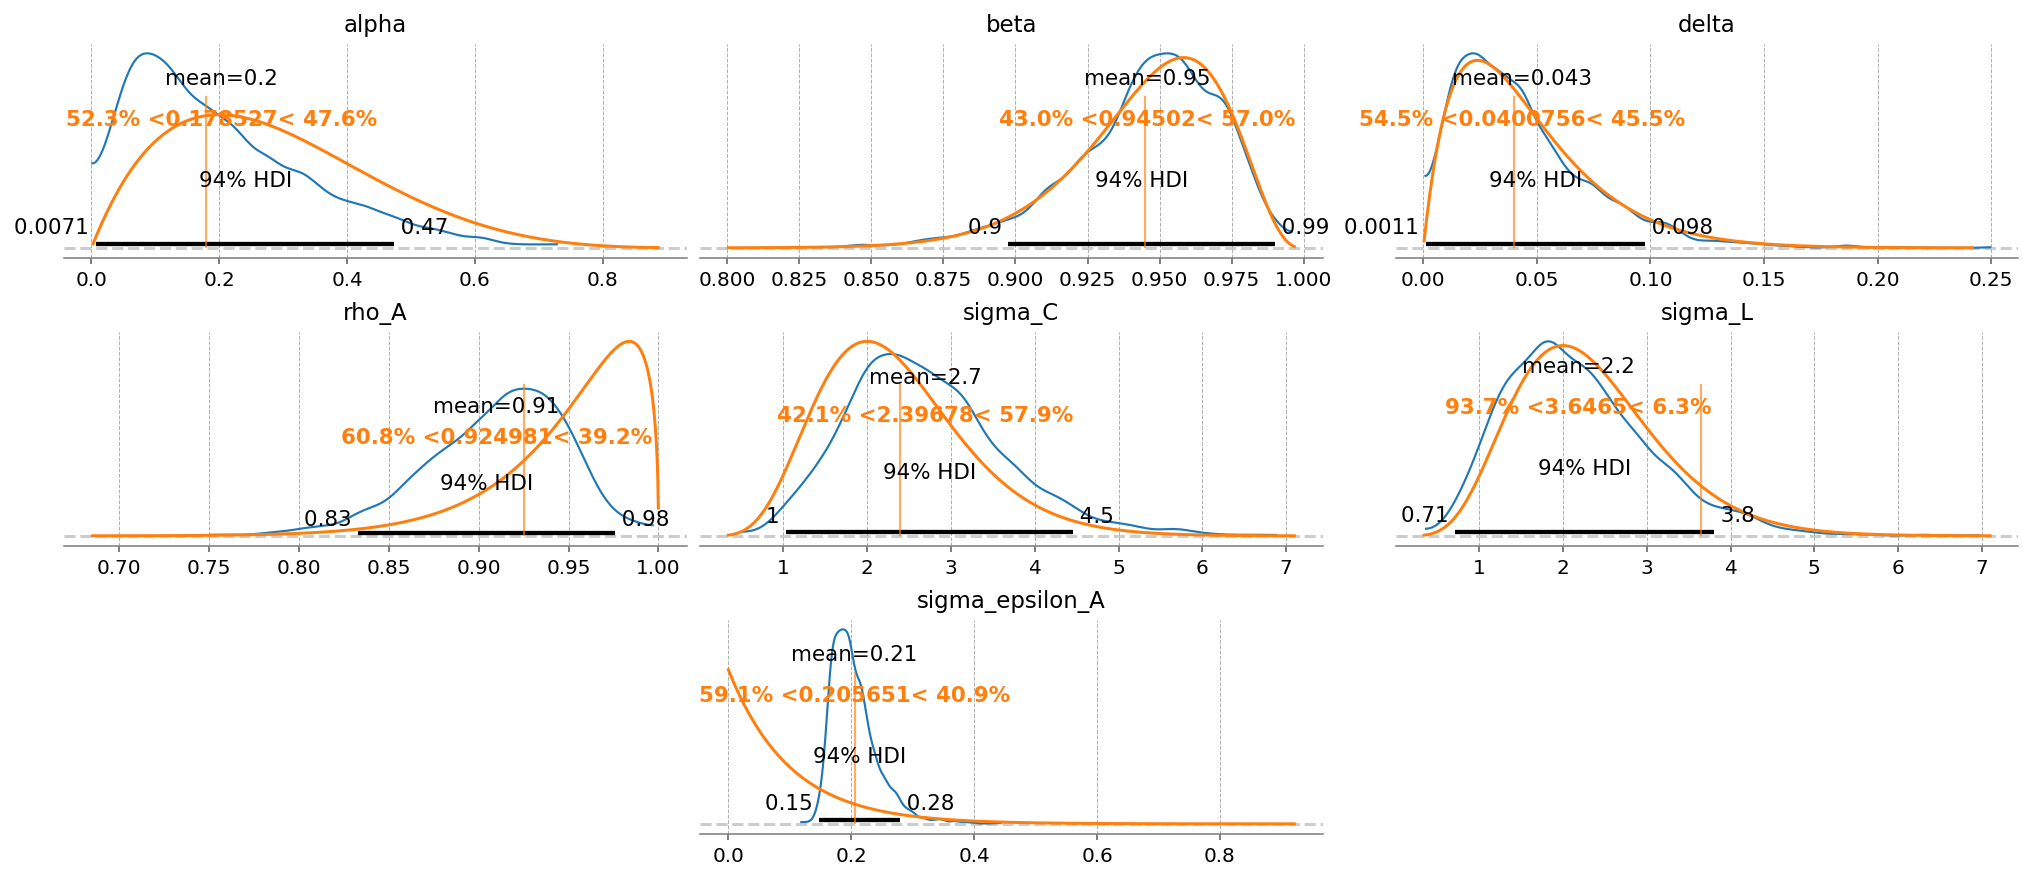

In [35]:
gp.plot_posterior_with_prior(
    idata_nuts,
    var_names=deep_params,
    prior_dict=prior_dict,
    true_values=true_params,
    n_cols=3,
);

Aside from getting much nicer looking posteriors, we also get many many more effective samples using NUTS. This is why it is strongly preferred over MH. Sampling 4000 draws with MH resulted in between 150 - 2000 effective draws (bulk + tail), while sampling with NUTS result in 2000-5000! The r_hat statistic also indicates much better mixing with NUTS, suggesting all the chains independently converged to the true posterior.

There were two divergences in NUTS, whic suggests there might be some areas of ugly posterior geometry that we were unable to sample. This is expected, because DSGE models have so many numerical hoops that need to be jumped through for a successful fit: steady state, linearization, blanchard-khan conditions, and finding the optimal policy function. The sampler can't see all of this, so it's a miracle we get samples at all.

In [36]:
import pandas as pd

mh_stats = az.summary(idata_mh, var_names=deep_params)[
    ["ess_bulk", "ess_tail", "r_hat"]
].assign(model="Metropolis-Hastings")
nuts_stats = az.summary(idata_nuts, var_names=deep_params)[
    ["ess_bulk", "ess_tail", "r_hat"]
].assign(model="NUTS")
pd.concat([mh_stats, nuts_stats]).reset_index().set_index(["index", "model"]).unstack(
    "model"
)

ess_bulk                    ess_tail          \
model           Metropolis-Hastings    NUTS Metropolis-Hastings    NUTS   
index                                                                     
alpha                         209.0  2159.0               383.0  1728.0   
beta                          417.0  4010.0               527.0  2376.0   
delta                         404.0  3488.0               652.0  2382.0   
rho_A                         196.0  2043.0               451.0  1917.0   
sigma_C                        84.0  2091.0               185.0  2169.0   
sigma_L                       601.0  3835.0               613.0  2375.0   
sigma_epsilon_A                51.0  1407.0                89.0  1605.0   

                              r_hat       
model           Metropolis-Hastings NUTS  
index                                     
alpha                          1.01  1.0  
beta                           1.01  1.0  
delta                          1.01  1.0  
rho_A                          1.02  1.0  
sigma_C                        1.05  1.0  
sigma_L                        1.01  1.0  
sigma_epsilon_A                1.07  1.0

# Comparing Results

We can compare the estimated posteriors between the three methods. On this simple RBC, they don't disagree so much. Laplace is fast, but the posterior doesn't respect the economic constraints imposed on the problem (we have alpha and delta less than 0, for example!). NUTS should be considered the "ground truth" because of its ability to completely explore the posterior space. 

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

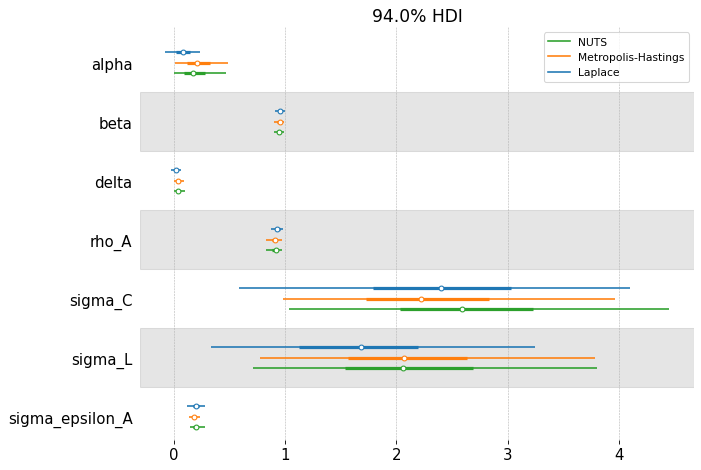

In [37]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=77)
az.plot_forest(
    [idata_laplace, idata_mh, idata_nuts],
    combined=True,
    var_names=deep_params,
    model_names=["Laplace", "Metropolis-Hastings", "NUTS"],
    ax=ax,
)

## Post-Estimation 

Once we have a trace object, we can sample conditional and unconditional trajectories from the posterior

In [38]:
conditional_posterior = ss_mod.sample_conditional_posterior(idata_nuts)

/home/jesse/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7FB0BB9C5380>), RNG(<Generator(PCG64) at 0x7FB0BB9C5000>), RNG(<Generator(PCG64) at 0x7FB0BB9C52A0>), RNG(<Generator(PCG64) at 0x7FB0BB9C5A80>), RNG(<Generator(PCG64) at 0x7FB0BB9C4740>), RNG(<Generator(PCG64) at 0x7FB0BA60FE60>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

The estimation procedure does a good job recovering latent states in most cases. Investment stands out as a miss -- the estimated posterior is more volatile than the actual (hidden) data. This is a known limitation of the basic RBC model -- investment jumps around too much. Notice the y-axis scale -- 20x larger than the size of the input shocks (as represented by variance in $A$)! 


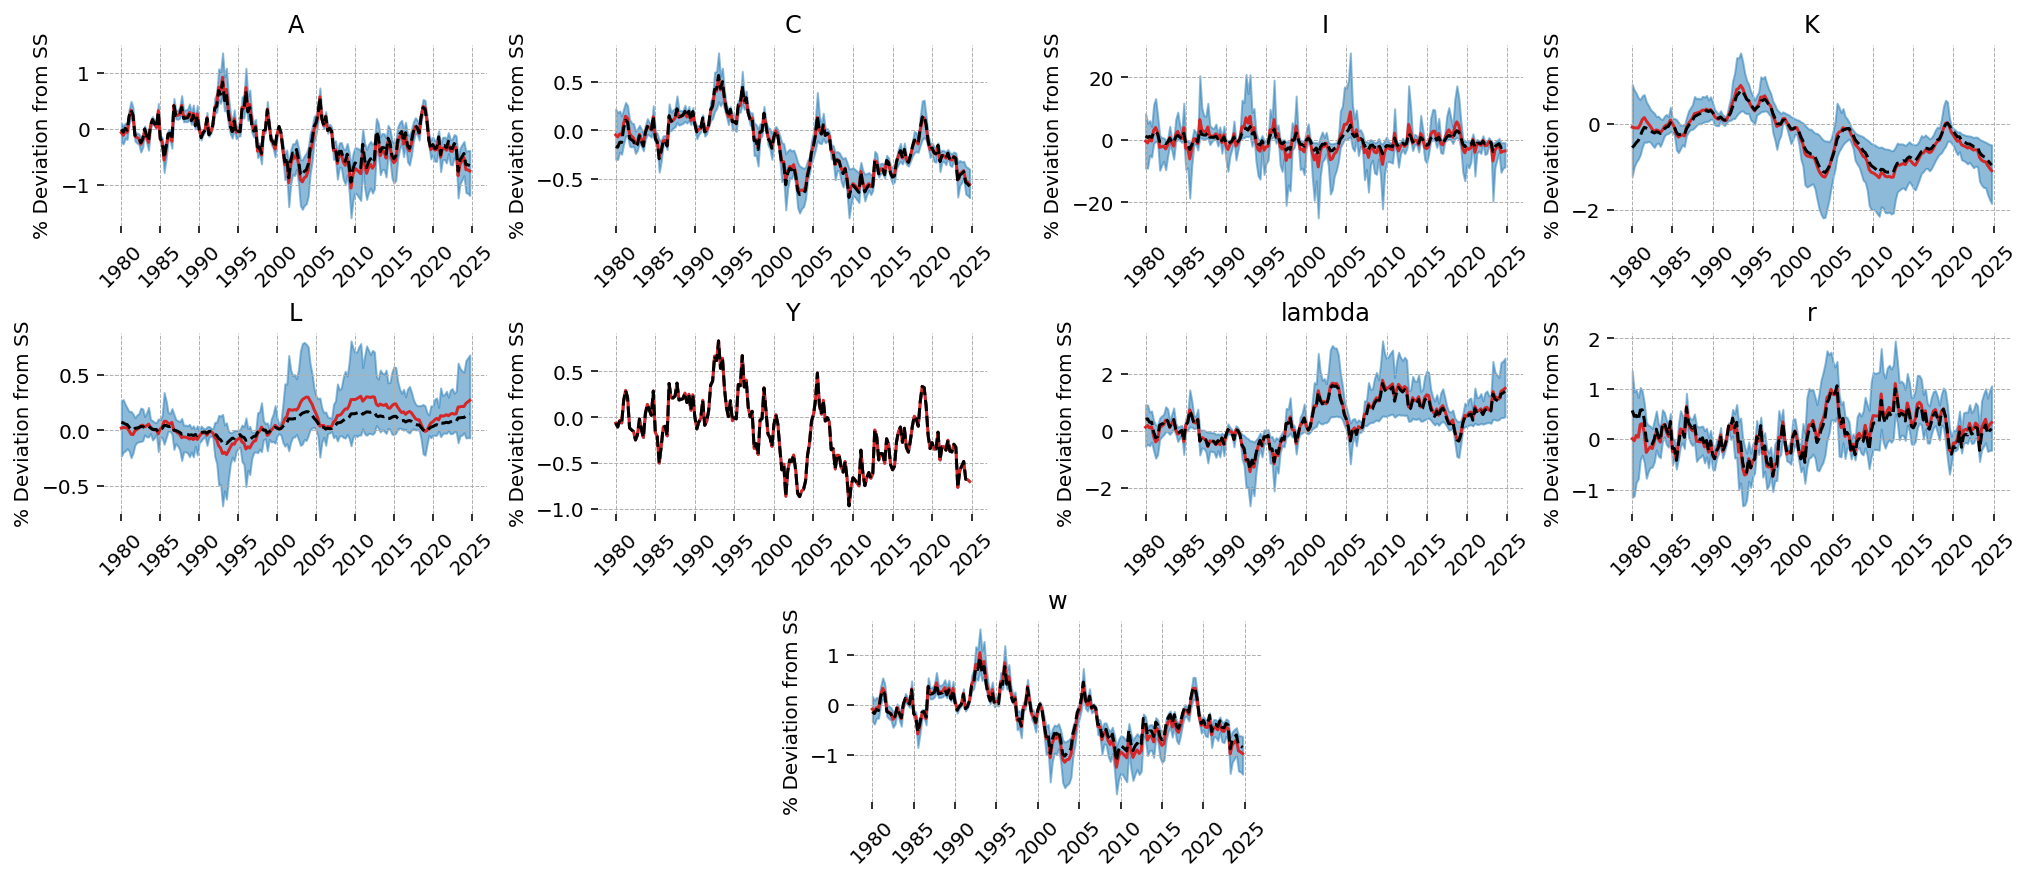

In [39]:
fig = gp.plot_kalman_filter(
    conditional_posterior, latent_data, kalman_output="smoothed"
);